In [31]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']
df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.1, random_state = 415);
train_df.head()

,Image name,Retinopathy grade
118,IDRiD_119,4
391,IDRiD_392,4
41,IDRiD_042,2
44,IDRiD_045,2
216,IDRiD_217,0


In [4]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 371


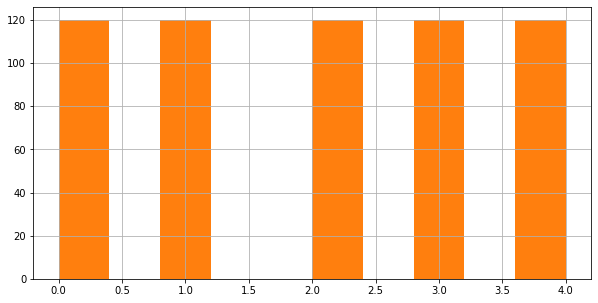

In [5]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [6]:
image_names = train_df['Image name'];
im_size = 224;

train_labels = [];
for label in train_df['Retinopathy grade']:
    for i in range(5): # 5 times for data augmentation
        train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((5*len(train_df['Image name']),224,224,3))
rot=[-6,-5,-4,-3,-2,2,3,4,5,6]
index=0
for image_name in image_names:
    #read image
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index] = img
    train_images[index + 1] = np.flip(img, axis = 0)
    train_images[index + 2] = np.flip(img, axis = 1)
    train_images[index + 3] = np.rot90(np.rot90(img))
    train_images[index + 4] = scipy.ndimage.rotate(img, random.choice(rot), reshape = False)
    index = index + 5


train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  3000
(3000, 224, 224, 3)
(3000, 5)


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

## Read and undersample test_df

---




In [7]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


In [ ]:
#undersample
#test_df = balance_data(test_df.pivot_table(index='Retinopathy grade', aggfunc=len).min().min(),test_df) # I will oversample such that all classes have the same number of images as the maximum
#test_df['Retinopathy grade'].hist(figsize = (10, 5))

In [8]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 224;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

#enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 224, 224, 3)
(103, 5)


In [9]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of test set ",len(val_image_names))
im_size = 224;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);

val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of test set  42
(42, 224, 224, 3)
(42, 5)


In [10]:
from sklearn.utils import shuffle

train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (3000, 224, 224, 3)
train y size  (3000, 5)
test x size  (103, 224, 224, 3)
test y size  (103, 5)
val x size  (42, 224, 224, 3)
val y size  (42, 5)


In [33]:
from keras.models import Sequential
#from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.models import model_from_json
#base_model = ResNet50(include_top=False,weights=None,input_shape=(224,224,3))

json_file = open("/content/drive/My Drive/IDRid/model_gradingNew.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

base_model=model_from_json(loaded_model_json)
base_model.load_weights("/content/drive/My Drive/IDRid/model_gradingNew.h5")

In [34]:
#base_model.summary()

In [35]:
layers=base_model.layers
last_layers=[]
#add last layers name
for i in range(14):
  last_layers.append(layers[-i-1].name)

set_trainable = False
for layer in base_model.layers:
    if layer.name in last_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(15)

,Layer Type,Layer Name,Layer Trainable
213,<tensorflow.python.keras.layers.core.Dropout o...,dropout_96,False
214,<tensorflow.python.keras.layers.convolutional....,conv2d_104,True
215,<tensorflow.python.keras.layers.normalization_...,batch_normalization_104,True
216,<tensorflow.python.keras.layers.core.Activatio...,activation_96,True
217,<tensorflow.python.keras.layers.core.Dropout o...,dropout_97,True
218,<tensorflow.python.keras.layers.convolutional....,conv2d_105,True
219,<tensorflow.python.keras.layers.normalization_...,batch_normalization_105,True
220,<tensorflow.python.keras.layers.merge.Add obje...,add_31,True
221,<tensorflow.python.keras.layers.core.Activatio...,activation_97,True
222,<tensorflow.python.keras.layers.core.Dropout o...,dropout_98,True


In [36]:
print("weights:", len(base_model.weights))
print("trainable_weights:", len(base_model.trainable_weights))
print("non_trainable_weights:", len(base_model.non_trainable_weights))

weights: 322
trainable_weights: 12
non_trainable_weights: 310


In [37]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(base_model.trainable_weights)
non_trainable_count = count_params(base_model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 25,947,781
Trainable params: 5,775,621
Non-trainable params: 20,172,160


In [51]:
output=base_model.layers[-3].output
model_wot=Model(base_model.input,output)
model= Sequential()#
model.add(model_wot)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 18432)             23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 645       
Total params: 28,340,101
Trainable params: 8,167,941
Non-trainable params: 20,172,160
__________________________________

In [52]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 10)
hist=model.fit(train_images, train_labels, epochs = 100, batch_size = 32, validation_data = (val_images, val_labels), callbacks = [early_stopping], shuffle = True);

Epoch 1/100
94/94 [==============================] - 21s 179ms/step - loss: 1.9020 - accuracy: 0.2547 - val_loss: 1.4669 - val_accuracy: 0.3333
Epoch 2/100
94/94 [==============================] - 16s 165ms/step - loss: 1.4520 - accuracy: 0.3883 - val_loss: 1.3775 - val_accuracy: 0.4048
Epoch 3/100
94/94 [==============================] - 16s 167ms/step - loss: 1.3621 - accuracy: 0.4185 - val_loss: 1.4712 - val_accuracy: 0.3095
Epoch 4/100
94/94 [==============================] - 16s 168ms/step - loss: 1.2365 - accuracy: 0.4839 - val_loss: 1.3544 - val_accuracy: 0.4286
Epoch 5/100
94/94 [==============================] - 16s 169ms/step - loss: 1.1415 - accuracy: 0.5331 - val_loss: 1.4234 - val_accuracy: 0.4286
Epoch 6/100
94/94 [==============================] - 16s 169ms/step - loss: 1.0880 - accuracy: 0.5456 - val_loss: 1.2515 - val_accuracy: 0.4286
Epoch 7/100
94/94 [==============================] - 16s 168ms/step - loss: 1.0496 - accuracy: 0.5812 - val_loss: 1.3852 - val_accuracy:

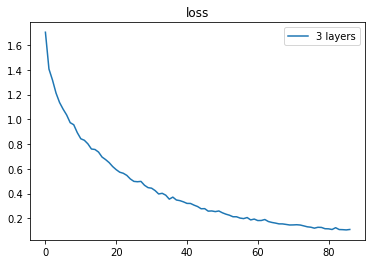

In [53]:
plt.plot(hist.history['loss'][0:],label="{} layers".format(3))
plt.legend()
plt.title('loss')
plt.show()

4/4 [==============================] - 0s 83ms/step - loss: 3.6906 - accuracy: 0.3883
Loss = 3.6906094551086426
Test accuracy = 0.3883495032787323
[[18  0 11  1  4]
 [ 3  0  1  0  1]
 [ 5  2 13  2 10]
 [ 3  0  6  4  6]
 [ 5  0  2  1  5]]


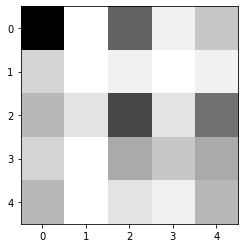

In [54]:
preds = model.evaluate(test_images, test_labels)
print("Loss = " + str(preds[0]))
print("Test accuracy = " + str(preds[1]))
pred_y_=model.predict(test_images)
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

[[13  0  0  0  1]
 [ 0  0  0  0  0]
 [ 5  0  6  4  4]
 [ 1  0  2  0  2]
 [ 1  1  0  0  2]]
0.5  acuracy


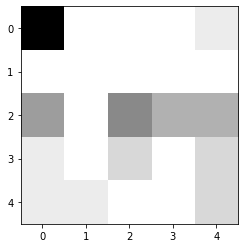

In [55]:
pred_y_=model.predict(val_images)
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary') 
score=accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

[[574   0  21   0   5]
 [ 33 494  56   0  17]
 [ 10   1 557  11  21]
 [ 27   2  58 451  62]
 [  0   0   2   0 598]]


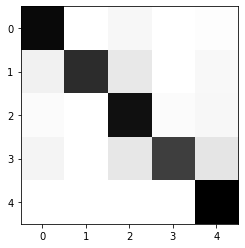

In [56]:
pred_y_=model.predict(train_images)
cm=confusion_matrix(np.argmax(train_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary') 

In [57]:
from sklearn.metrics import precision_score,accuracy_score
score=accuracy_score(np.argmax(train_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

0.8913333333333333  acuracy


In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import multiprocessing
import tools.image as T

pool = multiprocessing.Pool(processes=5)

train_datagen = T.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    pool=pool)
train_generator = train_datagen.flow_from_dataframe(
    'data/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

ModuleNotFoundError: ignored

In [49]:
pip install tools

     |████████████████████████████████| 92kB 7.0MB/s 
  Created wheel for tools: filename=tools-0.1.9-cp37-none-any.whl size=46760 sha256=b524afe4aeab38a943be3bc02ba4456e99d3deb81268ad55489b1f3df2659f3b
  Stored in directory: /root/.cache/pip/wheels/87/67/9b/1ca7dcb0b9ebfdc23a00c85a0644abb6fb14f9159a0df8e067
  Created wheel for pytils: filename=pytils-0.3-cp37-none-any.whl size=40356 sha256=b6645ecdf1662fc7f556772379546bcc6c6707f0f8f17f49e1d4d82ad5eafbf5
  Stored in directory: /root/.cache/pip/wheels/d6/f9/dc/4f07d8ee40d9cfca9973b3f4aeff99d0bb69900e5f3dffbf32
Successfully built tools pytils
